# Fruit Classification:


In [1]:
%pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
%pip install torchvision
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import json
from torchsummary import summary
from collections import Counter
%pip install scikit-learn
from sklearn.metrics import accuracy_score, f1_score
%pip install opencv-python
import cv2
%pip install tqdm
from tqdm import tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


1. Data loading
2. Define model
4. Train and evaluate model

## Configurations

In [2]:
image_size = 224
batch_size = 9
num_workers = 2
learning_rate = 1e-4
num_epoch = 10

## Data Loading

In [3]:
# Load data from ./fruits_train as training set
train_set = torchvision.datasets.ImageFolder(root='./fruits_train', transform=transforms.Compose([transforms.Resize((image_size, image_size)),
                                                                                                  transforms.RandomRotation(45),
                                                                                                  transforms.ToTensor()]))

# Load data from ./fruits_eval as evaluation set
val_set = torchvision.datasets.ImageFolder(root='./fruits_eval', transform=transforms.Compose([transforms.Resize((image_size, image_size)),
                                                                                                  transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

# Dataset Visualization

In [4]:
# Function to count samples per class
def count_samples_per_class(dataset):
    labels = [label for _, label in dataset]
    label_count = Counter(labels)
    return label_count

label_count = count_samples_per_class(val_set)
num_classes = len(label_count)
print("Total number of data: ", len(val_set))
print("Number of classes:", num_classes)
print("Number of data samples per class:", label_count)

Total number of data:  359
Number of classes: 9
Number of data samples per class: Counter({0: 40, 1: 40, 2: 40, 3: 40, 4: 40, 5: 40, 7: 40, 8: 40, 6: 39})


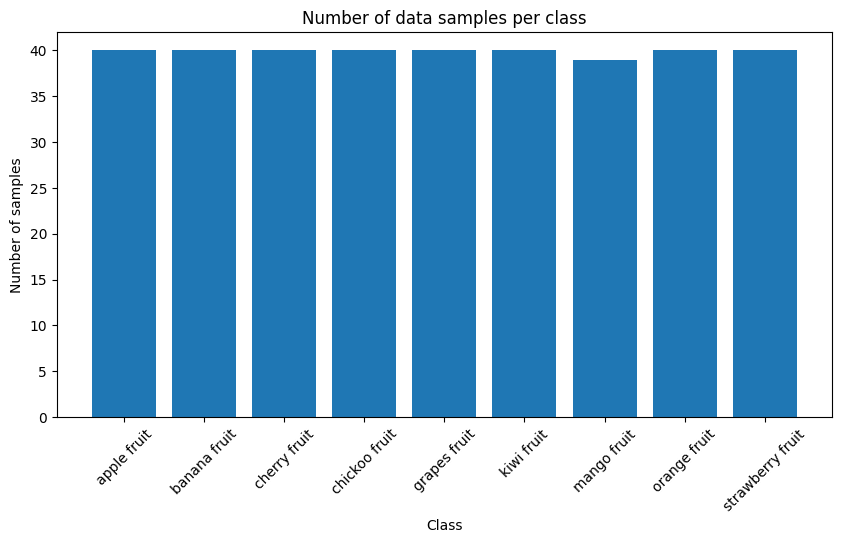

In [5]:
# Function to plot graph number of data samples per class

def plot_samples_per_class(dataset, title):
    labels = [label for _, label in dataset]
    label_count = Counter(labels)
    
    # Change the labels to class names
    class_names = dataset.classes
    label_count = {class_names[label]: count for label, count in label_count.items()}
    
    plt.figure(figsize=(10, 5))
    plt.bar(label_count.keys(), label_count.values())
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of samples")
    plt.xticks(rotation=45)
    plt.show()

plot_samples_per_class(train_set, "Number of data samples per class")

In [6]:
cat_to_name = {
    '0': 'Apple', 
    '1': 'Banana', 
    '2': 'Cherry', 
    '3': 'Chickoo', 
    '4': 'Grapes', 
    '5': 'Kiwi', 
    '6': 'Mango',
    '7': 'Orange', 
    '8': 'Strawberry'}

def imshow(img_tensor, ax, label):
    """ Utility function to display an image tensor with a caption. """
    if img_tensor.shape[0] == 3:  # Check if it's an RGB image
        ax.imshow(img_tensor.permute(1, 2, 0))  # Reorder dimensions to (height, width, channels)
    else:
        ax.imshow(img_tensor[0], cmap='gray')  # Display the first channel (grayscale)
    ax.axis('off')
    ax.set_title(label, fontsize=10)

def show_images_batch(images_batch, labels):
    """
    Display a batch of images in a grid with labels.
    """

    batch_size = images_batch.shape[0]
    grid_cols = int(np.ceil(np.sqrt(batch_size)))
    grid_rows = int(np.ceil(batch_size / grid_cols))  # Ensure all images fit in the grid

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2.5, grid_rows * 2.5))
    if grid_rows * grid_cols == 1:  # Special case for single image
        axes = [axes]  # Make it iterable

    # Check if axes is still not iterable
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])


    for i in range(grid_rows * grid_cols):
        ax = axes.flatten()[i]
        if i < batch_size:
            # imshow(images_batch[i], ax, labels[i].item())
            imshow(images_batch[i], ax, cat_to_name[str(labels[i].item())])
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

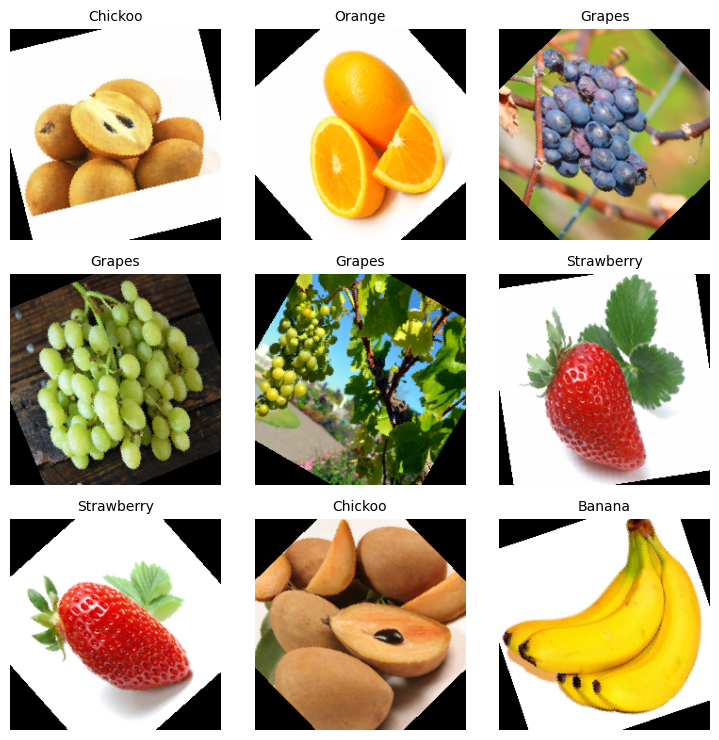

In [7]:
for idx, data in enumerate(train_loader):
  show_images_batch(images_batch=data[0], labels=data[1])
  break

## CNN Model

In [8]:
vgg_model = torchvision.models.vgg11(weights='IMAGENET1K_V1')

In [9]:
summary(vgg_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

### Changing the output layer

In [10]:
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vgg_model.parameters(), lr=learning_rate)

# Change the output layer to 9
vgg_model.classifier[6] = nn.Linear(4096, num_classes)

In [12]:
# vgg_model = vgg_model.cuda()

### Retraining the classification layers

In [13]:
for n, p in vgg_model.named_parameters():
  print(n)

features.0.weight
features.0.bias
features.3.weight
features.3.bias
features.6.weight
features.6.bias
features.8.weight
features.8.bias
features.11.weight
features.11.bias
features.13.weight
features.13.bias
features.16.weight
features.16.bias
features.18.weight
features.18.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [14]:
for p in vgg_model.named_parameters():
  if 'classifier' in p[0]:
    p[1].requires_grad = True

In [15]:
summary(vgg_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

In [16]:
best_val_accuracy = 0

train_loss_history = {}
train_accuracy_history = {}

for epoch_idx in range(num_epoch):

  train_running_loss = 0.0
  train_running_accuracy = 0.0

  idx = 0
  for idx, data in tqdm(enumerate(train_loader)):

    optimizer.zero_grad()

    images, labels = data
    # images = images.cuda()
    # labels = labels.cuda()

    pred = vgg_model(images)

    loss = loss_fn(pred, labels)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()

    _, pred_arr = torch.max(pred.detach(), 1)
    label_arr = labels.cpu().numpy()

    train_loss_history[epoch_idx] = train_running_loss
    train_accuracy_history[epoch_idx] = train_running_accuracy/(idx+1)

    train_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())


  print(f"Training Loss at epoch {epoch_idx} is {train_running_loss}")
  print(f"Training Accuracy at epoch {epoch_idx} is {train_running_accuracy/(idx+1)}")

40it [01:10,  1.76s/it]


Training Loss at epoch 0 is 60.14899528026581
Training Accuracy at epoch 0 is 0.47986111111111124


40it [01:09,  1.74s/it]


Training Loss at epoch 1 is 23.752964042127132
Training Accuracy at epoch 1 is 0.7888888888888893


40it [01:09,  1.73s/it]


Training Loss at epoch 2 is 13.768929619342089
Training Accuracy at epoch 2 is 0.8746527777777781


40it [01:08,  1.70s/it]


Training Loss at epoch 3 is 12.856261787354015
Training Accuracy at epoch 3 is 0.8972222222222224


40it [01:09,  1.74s/it]


Training Loss at epoch 4 is 6.72645762283355
Training Accuracy at epoch 4 is 0.9388888888888888


40it [01:09,  1.74s/it]


Training Loss at epoch 5 is 7.729023945663357
Training Accuracy at epoch 5 is 0.9499999999999998


40it [01:09,  1.73s/it]


Training Loss at epoch 6 is 1.577190553995024
Training Accuracy at epoch 6 is 0.9833333333333332


40it [01:09,  1.74s/it]


Training Loss at epoch 7 is 6.21696605445959
Training Accuracy at epoch 7 is 0.9472222222222222


40it [01:08,  1.70s/it]


Training Loss at epoch 8 is 7.8580835255852435
Training Accuracy at epoch 8 is 0.9555555555555554


40it [01:09,  1.74s/it]

Training Loss at epoch 9 is 5.0731645770865725
Training Accuracy at epoch 9 is 0.9722222222222221


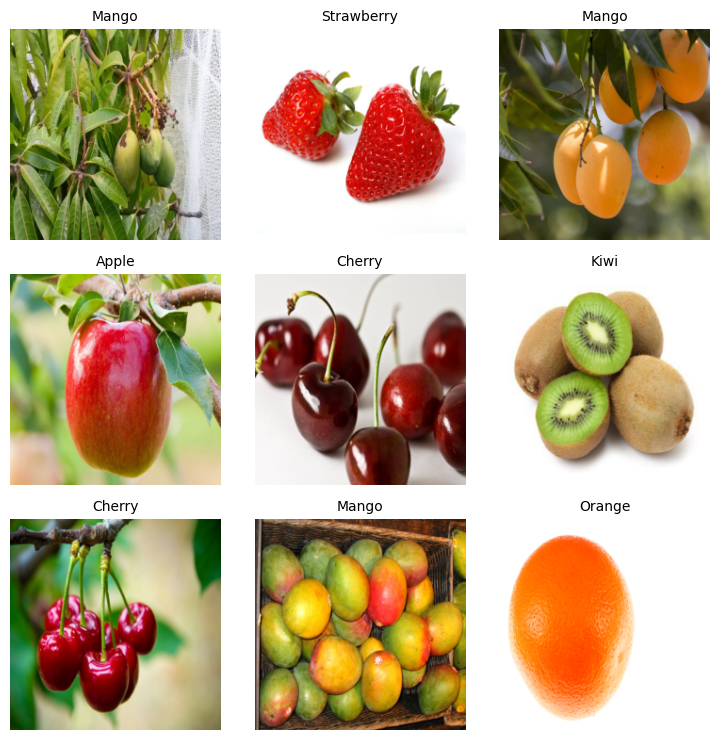

Validation Loss is 0.907857981743291
Validation Accuracy is 0.9797979797979799


In [17]:
val_running_loss = 0.0
val_running_accuracy = 0.0
idx = 0
for idx, data in enumerate(val_loader):


  images, labels = data
  # images = images.cuda()
  # labels = labels.cuda()

  pred = vgg_model(images)

  loss = loss_fn(pred, labels)

  val_running_loss += loss.item()

  _, pred_arr = torch.max(pred.detach(), 1)
  label_arr = labels.cpu().numpy()

  val_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())
  
  if idx == 0:
    show_images_batch(images, pred_arr)
  
  if idx == 10:
    break
  

print(f"Validation Loss is {val_running_loss}")
print(f"Validation Accuracy is {val_running_accuracy/(idx+1)}")



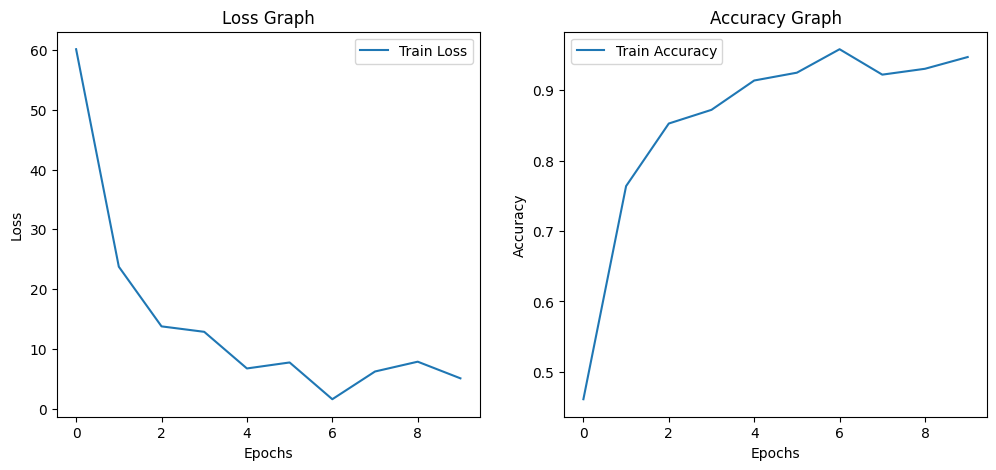

In [18]:
# Create a figure with two subplots
plt.figure(num=2, figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(list(train_loss_history.keys()), list(train_loss_history.values()), label='Train Loss')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(list(train_accuracy_history.keys()), list(train_accuracy_history.values()), label='Train Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the figure
plt.show()

In [19]:
# Save model

torch.save(vgg_model.state_dict(), 'fruit_classification.pth')